# This notebook replicates figures in the paper using application 2:
# Continuous housing stock with adjustment frictions

In [1]:
import numpy as np
import time
import yaml

# plotting
import seaborn as sns
import matplotlib.pylab as pl
from matplotlib.ticker import FormatStrFormatter

# local modules
from examples.housing_frictions import ConsumerProblem, Operator_Factory

C:\Users\alujan\mambaforge\envs\fues\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\alujan\mambaforge\envs\fues\lib\site-packages\quantecon\lss.py:20: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def simulate_linear_model(A, x0, v, ts_length):
C:\Users\alujan\mambaforge\envs\fues\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is d

In [2]:
# Read settings
with open("settings/settings.yml", "r") as stream:
    eggbasket_config = yaml.safe_load(stream)

# Generate class with settings
cp = ConsumerProblem(
    eggbasket_config,
    r=0.01,
    sigma=0.001,
    r_H=0,
    beta=0.93,
    alpha=0.03,
    delta=0,
    Pi=((0.5, 0.5), (0.5, 0.5)),
    z_vals=(0.1, 1),
    b=1e-10,
    grid_max_A=20.0,
    grid_max_WE=70,
    grid_size_W=10000,
    grid_max_H=50.0,
    grid_size=600,
    grid_size_H=300,
    gamma_c=3,
    chi=0,
    tau=0.18,
    K=1.3,
    tol_bel=1e-09,
    m_bar=0.8,
    theta=np.exp(0.3),
)

# unpack the Bellman operator
bellman_operator, coleman_operator, condition_V = Operator_Factory(cp)

# Initialise the initial value functions and marginal utilities
shape = (len(cp.z_vals), len(cp.asset_grid_A), len(cp.asset_grid_H))
shape_all = (60, len(cp.z_vals), len(cp.asset_grid_A), len(cp.asset_grid_H))

V_init, h_init, a_init = np.empty(shape), np.empty(shape), np.empty(shape)
V_init, Ud_prime_a_init, Ud_prime_h_init = (
    np.empty(shape),
    np.empty(shape),
    np.empty(shape),
)

for state in range(len(cp.X_all)):
    a = cp.asset_grid_A[cp.X_all[state][1]]
    h = cp.asset_grid_H[cp.X_all[state][2]]
    i_a = cp.X_all[state][1]
    i_h = cp.X_all[state][2]
    i_z = cp.X_all[state][0]
    z = cp.z_vals[i_z]

    V_init[i_z, i_a, i_h] = cp.term_u(cp.R_H * (1 - cp.delta) * h + cp.R * a)
    Ud_prime_a_init[i_z, i_a, i_h] = (
        cp.beta * cp.R * cp.term_du(cp.R_H * (1 - cp.delta) * h + cp.R * a)
    )
    Ud_prime_h_init[i_z, i_a, i_h] = (
        cp.beta
        * cp.beta
        * cp.R_H
        * cp.term_du(cp.R_H * (1 - cp.delta) * h + cp.R * a)
        * (1 - cp.delta)
    )

# Initialise empty arrays to fill with value and policy functions
# _vfi for value function iteration and _col for EGM
V_pol_vfi, h_pols_vfi, a_pols_vfi = (
    np.empty(shape_all),
    np.empty(shape_all),
    np.empty(shape_all),
)
V_pols, h_pols, a_pols, c_pol = (
    np.empty(shape_all),
    np.empty(shape_all),
    np.empty(shape_all),
    np.empty(shape_all),
)
a_pols_adj = np.empty(shape_all)
h_pols_adj = np.empty(shape_all)

In [3]:
# Start Bellman iteration
V = np.copy(V_init)
t = cp.T

term_t = 58

"""

while t>term_t:

    start = time.time()
    bellman_sol = bellman_operator(t,V)
    print("Bellman iteration no. {}, time is {}".format(t, time.time() -start ))

    a_pols_new, h_pols_new, new_V_uc, new_c, a_adj_pol, h_adj_pol\
     = bellman_sol

    # Condition the value function
    # new_UD_a and new_UD_h are dummy values here
    new_V, new_UD_a,new_UD_h = condition_V(new_V_uc, new_V_uc,new_V_uc)

    # iterate the value function
    V = np.copy(new_V)

    # Store solution in array
    a_pols[int(t-1)], h_pols[int(t-1)],V_pols[int(t-1)]\
     = np.copy(a_pols_new), np.copy(h_pols_new), np.copy(new_V)
    a_pols_adj[int(t-1)] = np.copy(a_adj_pol)
    c_pol[int(t-1)]  = new_c
    h_pols_adj[int(t-1)] = np.copy(h_adj_pol)
    V_pol_vfi[int(t-1)] = np.copy(new_V_uc)

    print(t)
    t = t-1

"""
# Now solve using EGM
V = np.copy(V_init)
Ud_prime_a = np.copy(Ud_prime_a_init)
Ud_prime_h = np.copy(Ud_prime_h_init)

V_pol_col, h_pols_col, a_pols_col = (
    np.empty(shape_all),
    np.empty(shape_all),
    np.empty(shape_all),
)
V_pol_col_adj, h_pols_col_adj, a_pols_col_adj = (
    np.empty(shape_all),
    np.empty(shape_all),
    np.empty(shape_all),
)
c_pol_col = np.empty(shape_all)

t = cp.T

# dictionaries for intermediate EGM grids
adj_ur_grids = {}
adj_ref_grids = {}
adj_nu_grid = {}

while t > term_t:
    start = time.time()
    (
        new_a_prime,
        new_h_prime,
        new_V_uc,
        new_UD_a_uc,
        new_UD_h_uc,
        new_c,
        new_h_prime_adj,
        new_a_prime_adj,
        new_c_adj,
        adj_ur_grids[t],
        adj_ref_grids[t],
        adj_nu_grid[t],
    ) = coleman_operator(t, V, Ud_prime_a, Ud_prime_h)
    print("EGM iteration no. {}, time is {}".format(t, time.time() - start))

    new_V, new_UD_a, new_UD_h = condition_V(new_V_uc, new_UD_a_uc, new_UD_h_uc)

    Ud_prime_a = np.copy(new_UD_a)
    Ud_prime_h = np.copy(new_UD_h)
    V = np.copy(new_V)

    V_pol_col[int(t - 1)] = np.copy(new_V_uc)
    a_pols_col[int(t - 1)] = np.copy(new_a_prime)
    h_pols_col[int(t - 1)] = np.copy(new_h_prime)
    c_pol_col[int(t - 1)] = np.copy(new_c)

    h_pols_col_adj[int(t - 1)] = np.copy(new_h_prime_adj)
    a_pols_col_adj[int(t - 1)] = np.copy(new_a_prime_adj)

    print(t)
    t = t - 1

EGM iteration no. 60, time is 41.47029781341553


60


EGM iteration no. 59, time is 9.46993374824524


59


C:\Users\alujan\AppData\Local\Temp\ipykernel_28616\2275130595.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_pol[0].set_yticklabels(ax_pol[0].get_yticks(), size=9)
C:\Users\alujan\AppData\Local\Temp\ipykernel_28616\2275130595.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_pol[0].set_xticklabels(ax_pol[0].get_xticks(), size=9)
C:\Users\alujan\AppData\Local\Temp\ipykernel_28616\2275130595.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_pol[1].set_yticklabels(ax_pol[0].get_yticks(), size=9)
C:\Users\alujan\AppData\Local\Temp\ipykernel_28616\2275130595.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_pol[1].set_xticklabels(ax_pol[0].get_xticks(), size=9)
C:\Users\alujan\AppData\Local\Temp\ipykernel_28616\2275130595.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_pol_a[0].set_yticklabels(ax_pol[0].

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


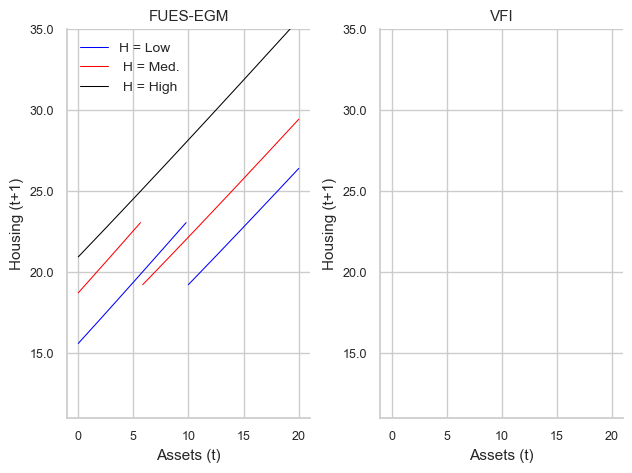

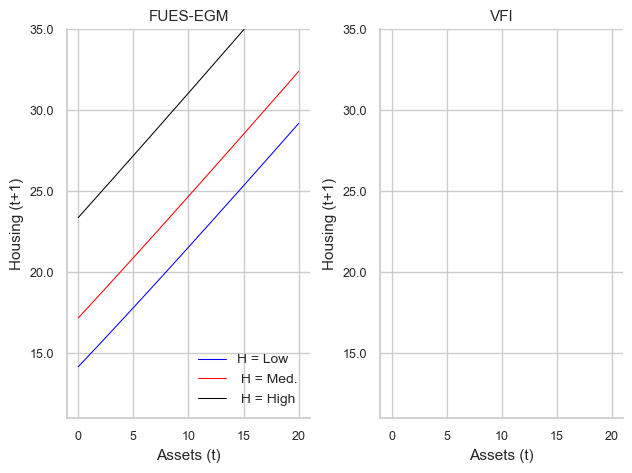

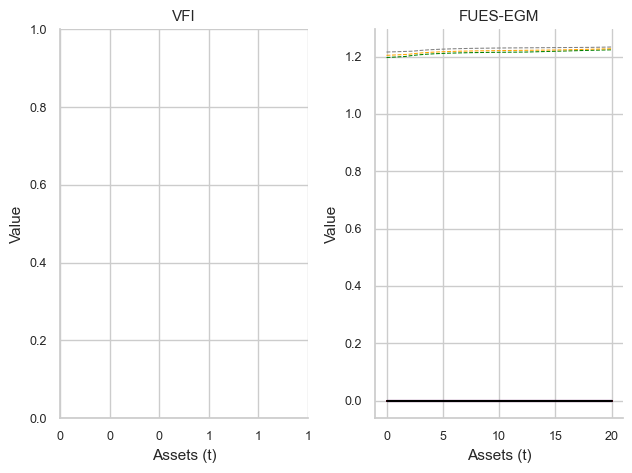

In [4]:
# Plotting

# First plot the overall policy function of housing on liq assets
# and vale function on liq assets

for plot_t in list(range(term_t, cp.T)):
    # plot_t = term_t

    pl.close()
    sns.set(
        style="whitegrid", rc={"font.size": 9, "axes.titlesize": 9, "axes.labelsize": 9}
    )

    colors = ["blue", "red", "black"]
    colors2 = ["green", "orange", "grey"]
    labs = ["H = Low", " H = Med.", " H = High"]

    fig_pol, ax_pol = pl.subplots(1, 2)
    fig_val, ax_val = pl.subplots(1, 2)
    fig_pol_a, ax_pol_a = pl.subplots(1, 2)

    for i_z in [1]:
        for col_ih, i_h, lbs in zip([0, 1, 2], [125, 150, 200], labs):
            pos_col = (
                np.where(np.abs(np.diff(h_pols_col_adj[plot_t, i_z, :, i_h])) > 0.09)[0]
                + 1
            )
            g_1 = np.insert(h_pols_col_adj[plot_t, i_z, :, i_h], pos_col, np.nan)
            x1 = np.insert(cp.asset_grid_A, pos_col, np.nan)

            pos_bell = (
                np.where(np.abs(np.diff(h_pols_adj[plot_t, i_z, :, i_h])) > 2)[0] + 1
            )
            g_2 = np.insert(h_pols_adj[plot_t, i_z, :, i_h], pos_bell, np.nan)
            x2 = np.insert(cp.asset_grid_A, pos_bell, np.nan)

            # g_1 = h_pols_col_adj[plot_t,0,:, i_h]
            # g_2 = h_pols_adj[plot_t,0,:, i_h]

            ax_pol[0].plot(x1, g_1, color=colors[col_ih], label=lbs, linewidth=0.75)
            ax_pol[1].plot(x2, g_2, color=colors[col_ih], label=lbs, linewidth=0.75)

            ax_pol[1].set_ylim(11, 35)
            ax_pol[0].set_ylim(11, 35)

            ax_val[1].plot(
                cp.asset_grid_A, V_pol_vfi[plot_t, i_z, :, i_h], color=colors[col_ih]
            )
            ax_val[1].plot(
                cp.asset_grid_A,
                V_pol_col[plot_t, i_z, :, i_h],
                linestyle="--",
                color=colors2[col_ih],
                linewidth=0.75,
            )

            # ax_pol_a[1].set_ylim(-0.5,7.5)
            # ax_pol_a[0].set_ylim(0,7.5)

            ax_pol[0].spines["right"].set_visible(False)
            ax_pol[0].spines["top"].set_visible(False)

            ax_val[0].spines["right"].set_visible(False)
            ax_val[0].spines["top"].set_visible(False)

            ax_pol[0].set_yticklabels(ax_pol[0].get_yticks(), size=9)
            ax_pol[0].set_xticklabels(ax_pol[0].get_xticks(), size=9)
            ax_pol[0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
            ax_pol[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
            ax_pol[1].set_xlabel("Assets (t)", fontsize=11)
            ax_pol[1].set_ylabel("Housing (t+1)", fontsize=11)
            ax_pol[0].set_xlabel("Assets (t)", fontsize=11)
            ax_pol[0].set_ylabel("Housing (t+1)", fontsize=11)
            ax_pol[1].spines["right"].set_visible(False)
            ax_pol[1].spines["top"].set_visible(False)
            ax_pol[0].spines["right"].set_visible(False)
            ax_pol[0].spines["top"].set_visible(False)
            ax_pol[1].set_yticklabels(ax_pol[0].get_yticks(), size=9)
            ax_pol[1].set_xticklabels(ax_pol[0].get_xticks(), size=9)
            ax_pol[1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
            ax_pol[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))

            pos_col_a = (
                np.where(np.abs(np.diff(a_pols_col_adj[plot_t, i_z, :, i_h])) > 0.08)[0]
                + 1
            )
            g_1a = np.insert(a_pols_col_adj[plot_t, i_z, :, i_h], pos_col_a, np.nan)
            x1a = np.insert(cp.asset_grid_A, pos_col_a, np.nan)

            pos_bell_a = (
                np.where(np.abs(np.diff(a_pols_adj[plot_t, i_z, :, i_h])) > 2)[0] + 1
            )
            g_2a = np.insert(a_pols_adj[plot_t, i_z, :, i_h], pos_bell, np.nan)
            x2a = np.insert(cp.asset_grid_A, pos_bell_a, np.nan)

            ax_pol_a[0].plot(x1a, g_1a, color=colors[col_ih], label=lbs, linewidth=0.75)
            ax_pol_a[1].plot(x2a, g_2a, color=colors[col_ih], label=lbs, linewidth=0.75)

            ax_pol_a[0].set_yticklabels(ax_pol[0].get_yticks(), size=9)
            ax_pol_a[0].set_xticklabels(ax_pol[0].get_xticks(), size=9)
            ax_pol_a[0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
            ax_pol_a[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
            ax_pol_a[1].set_xlabel("Assets (t)", fontsize=11)
            ax_pol_a[1].set_ylabel("Assets (t+1)", fontsize=11)
            ax_pol_a[0].set_xlabel("Assets (t)", fontsize=11)
            ax_pol_a[0].set_ylabel("Assets (t+1)", fontsize=11)
            ax_pol_a[1].spines["right"].set_visible(False)
            ax_pol_a[1].spines["top"].set_visible(False)
            ax_pol_a[0].spines["right"].set_visible(False)
            ax_pol_a[0].spines["top"].set_visible(False)
            ax_pol_a[1].set_yticklabels(ax_pol[0].get_yticks(), size=9)
            ax_pol_a[1].set_xticklabels(ax_pol[0].get_xticks(), size=9)
            ax_pol_a[1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
            ax_pol_a[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))

            ax_val[0].set_yticklabels(ax_val[0].get_yticks(), size=9)
            ax_val[0].set_xticklabels(ax_val[0].get_xticks(), size=9)
            ax_val[0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
            ax_val[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
            ax_val[1].set_xlabel("Assets (t)", fontsize=11)
            ax_val[1].set_ylabel("Value", fontsize=11)
            ax_val[0].set_xlabel("Assets (t)", fontsize=11)
            ax_val[0].set_ylabel("Value", fontsize=11)
            ax_val[1].spines["right"].set_visible(False)
            ax_val[1].spines["top"].set_visible(False)
            ax_val[0].spines["right"].set_visible(False)
            ax_val[0].spines["top"].set_visible(False)
            ax_val[1].set_yticklabels(ax_val[0].get_yticks(), size=9)
            ax_val[1].set_xticklabels(ax_val[0].get_xticks(), size=9)
            ax_val[1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
            ax_val[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))

            ax_val[0].legend(frameon=False, prop={"size": 10})
            ax_pol[0].legend(frameon=False, prop={"size": 10})

            ax_val[0].set_title("VFI", fontsize=11)
            ax_val[1].set_title("FUES-EGM", fontsize=11)

            ax_pol[0].set_title("FUES-EGM", fontsize=11)
            ax_pol[1].set_title("VFI", fontsize=11)

        fig_pol.tight_layout()
        fig_val.tight_layout()

    fig_pol.savefig("plots/housing/policy_adj_housing_{}.png".format(plot_t))
    fig_val.savefig("plots/housing/value_housing_{}.png".format(plot_t))
    fig_pol_a.savefig("plots/housing/policy_adj_assets_{}.png".format(plot_t))

    pl.close()

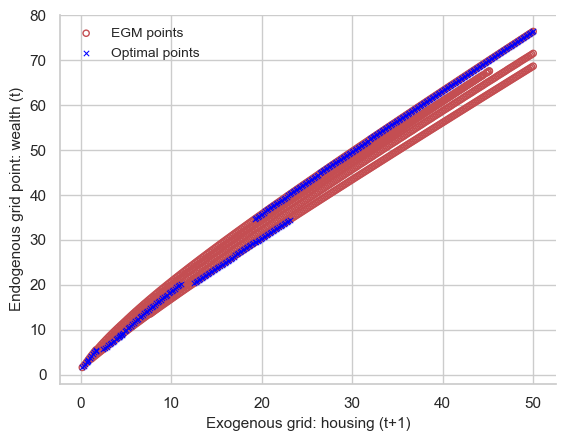

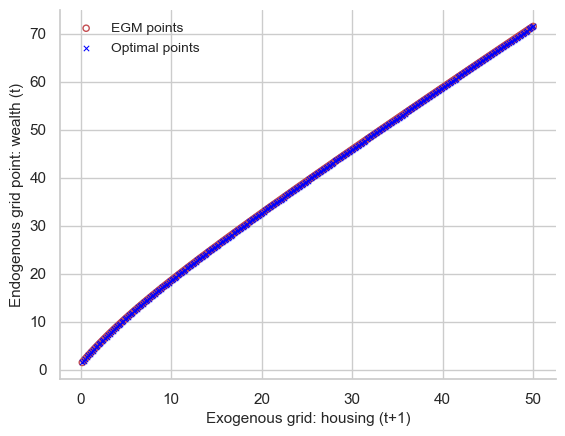

In [5]:
for j in list(range(term_t, cp.T)):
    # Test Scan Plots

    plot_t = j + 1

    fig, ax = pl.subplots(2, 2)

    # unrefined grids
    vf_unrefined = adj_ur_grids[plot_t]["vf_unrefined_adj"]
    e_grid_unrefined = adj_ur_grids[plot_t]["endog_grid_unrefined_adj"]
    a_prime_unrefined_adj = adj_ur_grids[plot_t]["a_prime_unrefined_adj"]
    h_prime_unrefined_adj = adj_ur_grids[plot_t]["h_prime_unrefined_adj"]

    # refined non-unform grids
    e_grid_cean = adj_nu_grid[plot_t]["e_grid_cean"]
    vf_clean = adj_nu_grid[plot_t]["vf_clean"]
    hprime_clean = adj_nu_grid[plot_t]["hprime_clean"]
    a_prime_clean = adj_nu_grid[plot_t]["a_prime_clean"]

    # uniform grids
    a_prime_adj = adj_ref_grids[plot_t]["a_prime_adj"]
    h_prime_adj = adj_ref_grids[plot_t]["h_prime_adj"]
    v_adj = adj_ref_grids[plot_t]["v_adj"]

    ax[0, 0].scatter(
        e_grid_unrefined, vf_unrefined, color="blue", s=15, marker="x", linewidth=0.75
    )

    ax[0, 0].scatter(
        e_grid_cean, vf_clean, color="red", s=15, marker="o", linewidth=0.75
    )

    ax[0, 0].set_ylim(10, 12)

    ax[0, 1].scatter(
        e_grid_unrefined,
        h_prime_unrefined_adj,
        color="blue",
        s=15,
        marker="x",
        linewidth=0.75,
    )
    ax[0, 1].scatter(
        e_grid_cean, hprime_clean, color="red", s=15, marker="o", linewidth=0.75
    )

    ax[1, 0].scatter(
        h_prime_unrefined_adj,
        e_grid_unrefined,
        color="blue",
        s=15,
        marker="x",
        linewidth=0.75,
    )
    ax[1, 0].scatter(
        hprime_clean, e_grid_cean, color="blue", s=15, marker="x", linewidth=0.75
    )

    ax[1, 1].plot(e_grid_cean, hprime_clean, color="blue", linewidth=0.75)

    fig.savefig("plots/housing/scan_test_{}.png".format(plot_t))

    # FUES-EGM Plots for paper

    pl.close()
    fig, ax = pl.subplots(1, 2)
    sns.set(
        style="whitegrid", rc={"font.size": 9, "axes.titlesize": 9, "axes.labelsize": 9}
    )

    ax[0].scatter(
        e_grid_unrefined[1:], vf_unrefined[1:], s=20, facecolors="none", edgecolors="r"
    )
    ax[0].plot(
        e_grid_cean[1:],
        vf_clean[1:],
        color="black",
        linewidth=1,
        label="Value function",
    )
    ax[0].scatter(
        e_grid_cean[1:], vf_clean[1:], color="blue", s=15, marker="x", linewidth=0.75
    )

    ax[0].set_ylim(1.68, 1.72)
    ax[0].set_xlim(30, 40)
    # ax[0].set_ylim(11.68,11.79)
    # ax[0].set_xlim(48,56)
    ax[0].set_xlabel("Wealth (t)", fontsize=11)
    ax[0].set_ylabel("Value", fontsize=11)
    ax[0].spines["right"].set_visible(False)
    ax[0].spines["top"].set_visible(False)
    ax[0].legend(frameon=False, prop={"size": 10})
    # ax[0].set_yticklabels(ax[0].get_yticks(), size=9)
    # ax[0].set_xticklabels(ax[0].get_xticks(), size=9)
    # ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    # ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))

    ax[1].scatter(
        e_grid_unrefined,
        h_prime_unrefined_adj,
        s=20,
        facecolors="none",
        edgecolors="r",
        label="EGM points",
    )
    ax[1].scatter(
        e_grid_cean,
        hprime_clean,
        s=20,
        color="blue",
        marker="x",
        linewidth=0.75,
        label="Optimal points",
    )

    # ax[1].set_ylim(20,40)
    # ax[1].set_xlim(44, 54.2)
    ax[1].set_ylim(10, 40)
    ax[1].set_xlim(30, 40)
    ax[1].set_ylabel("Housing (t+1)", fontsize=11)
    ax[1].set_xlabel("Wealth (t)", fontsize=11)
    ax[1].spines["right"].set_visible(False)
    ax[1].spines["top"].set_visible(False)
    # ax[1].set_yticklabels(ax[1].get_yticks(), size=9)
    # ax[1].set_xticklabels(ax[1].get_xticks(), size=9)
    # ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    # ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    fig.tight_layout()
    ax[1].legend(frameon=False, prop={"size": 10})
    fig.savefig("plots/housing/hous_vf_aprime_all_small_{}.png".format(plot_t))

    # Plot all EGM points
    pl.close()
    pos = np.where(np.abs(np.diff(hprime_clean)) > 0.4)[0] + 1
    y1 = np.insert(hprime_clean, pos, np.nan)
    x1 = np.insert(e_grid_cean, pos, np.nan)

    fig, ax = pl.subplots(1, 1)
    sns.set(
        style="white", rc={"font.size": 9, "axes.titlesize": 9, "axes.labelsize": 9}
    )

    ax.scatter(
        h_prime_unrefined_adj[1:],
        e_grid_unrefined[1:],
        s=20,
        facecolors="none",
        edgecolors="r",
        label="EGM points",
    )

    ax.scatter(
        hprime_clean[1:],
        e_grid_cean[1:],
        color="blue",
        s=15,
        marker="x",
        linewidth=0.75,
        label="Optimal points",
    )

    # ax[0].set_ylim(7.75, 8.27)
    # ax[0].set_xlim(30, 40)
    # ax[0].set_ylim(7.3,8)
    # ax.set_xlim(0,75)
    ax.set_xlabel("Exogenous grid: housing (t+1)", fontsize=11)
    ax.set_ylabel("Endogenous grid point: wealth (t)", fontsize=11)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.legend(frameon=False, prop={"size": 10})
    # ax[0].set_yticklabels(ax[0].get_yticks(), size=9)
    # ax[0].set_xticklabels(ax[0].get_xticks(), size=9)
    # ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    # ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    """
    ax[1].scatter(
        e_grid_unrefined,
        h_prime_unrefined_adj,
        s=20,
        facecolors='none',
        edgecolors='r',
        label='EGM points')
    ax[1].scatter(
        e_grid_cean,
        hprime_clean,
        s=20,
        color='blue',
        marker='x',
        linewidth=0.75,
        label='Optimal points')

    #ax[1].set_ylim(20,40)
    #ax[1].set_xlim(44, 54.2)
    #ax[1].set_ylim(5,40)
    #ax[1].set_xlim(30, 40)
    ax[1].set_ylabel('Housing (t+1)', fontsize=11)
    ax[1].set_xlabel('Wealth (t+1)', fontsize=11)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    # ax[1].set_yticklabels(ax[1].get_yticks(), size=9)
    #ax[1].set_xticklabels(ax[1].get_xticks(), size=9)
    #ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    #ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    fig.tight_layout()
    ax[1].legend(frameon=False, prop={'size': 10})
    """
    fig.savefig("plots/housing/hous_vf_aprime_all_big_{}.png".format(plot_t))